# CIFAR-10 Classification with a Softmax Head
This notebook trains a lightweight convolutional encoder with a softmax classifier head on CIFAR-10, then visualises the learned embedding space.


### Setup


In [1]:
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)


device = cuda


### Data


In [3]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2470, 0.2435, 0.2616)
pin_memory = torch.cuda.is_available()

train_tfm = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tfm = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.CIFAR10(root='./data', train=True, transform=train_tfm, download=True)
test_ds  = datasets.CIFAR10(root='./data', train=False, transform=test_tfm, download=True)
train_ld = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=4, pin_memory=pin_memory)
test_ld  = DataLoader(test_ds,  batch_size=1024, shuffle=False, num_workers=4, pin_memory=pin_memory)
len(train_ds), len(test_ds)


(50000, 10000)

### Model: encoder + softmax head


In [4]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
        )
        self.proj = nn.Linear(256, dim)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.proj(x)

class SoftmaxHead(nn.Module):
    def __init__(self, D, C):
        super().__init__()
        self.linear = nn.Linear(D, C)

    def forward(self, z):
        return self.linear(z)

class DeepClassifier(nn.Module):
    def __init__(self, C, D):
        super().__init__()
        self.encoder = Encoder(D)
        self.head = SoftmaxHead(D, C)

    def forward(self, x):
        z = self.encoder(x)
        return self.head(z)


### Train & Eval


In [5]:
@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    ok = tot = 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        ok += (logits.argmax(1) == y).sum().item()
        tot += y.size(0)
    return ok / tot

model = DeepClassifier(C=10, D=9).to(device)
opt = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

train_acc = []
test_acc = []

for epoch in range(1, 101):
    model.train()
    loss_sum = acc_sum = n_sum = 0
    for x, y in train_ld:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = loss_fn(logits, y)
        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()
        with torch.no_grad():
            pred = logits.argmax(1)
            acc_sum += (pred == y).sum().item()
            n_sum += y.size(0)
            loss_sum += loss.item() * y.size(0)
    tr_acc = acc_sum / n_sum
    te_acc = evaluate(model, test_ld)
    train_acc.append(tr_acc)
    test_acc.append(te_acc)
    print(f"[{epoch:02d}] train loss={loss_sum/n_sum:.4f} acc={tr_acc:.4f} | test acc={te_acc:.4f}")


[01] train loss=1.4133 acc=0.4864 | test acc=0.4200
[02] train loss=0.9732 acc=0.6528 | test acc=0.6046
[03] train loss=0.7986 acc=0.7187 | test acc=0.6830
[04] train loss=0.6803 acc=0.7619 | test acc=0.7151
[05] train loss=0.5918 acc=0.7952 | test acc=0.7567
[06] train loss=0.5305 acc=0.8161 | test acc=0.7642
[07] train loss=0.4790 acc=0.8335 | test acc=0.7633
[08] train loss=0.4461 acc=0.8457 | test acc=0.7803
[09] train loss=0.4115 acc=0.8553 | test acc=0.7557
[10] train loss=0.3835 acc=0.8675 | test acc=0.7872
[11] train loss=0.3586 acc=0.8758 | test acc=0.7975
[12] train loss=0.3389 acc=0.8819 | test acc=0.8096
[13] train loss=0.3198 acc=0.8905 | test acc=0.8297
[14] train loss=0.3034 acc=0.8922 | test acc=0.8293
[15] train loss=0.2845 acc=0.9000 | test acc=0.8545
[16] train loss=0.2695 acc=0.9061 | test acc=0.8204
[17] train loss=0.2561 acc=0.9108 | test acc=0.8309
[18] train loss=0.2455 acc=0.9145 | test acc=0.8673
[19] train loss=0.2289 acc=0.9192 | test acc=0.8686
[20] train l

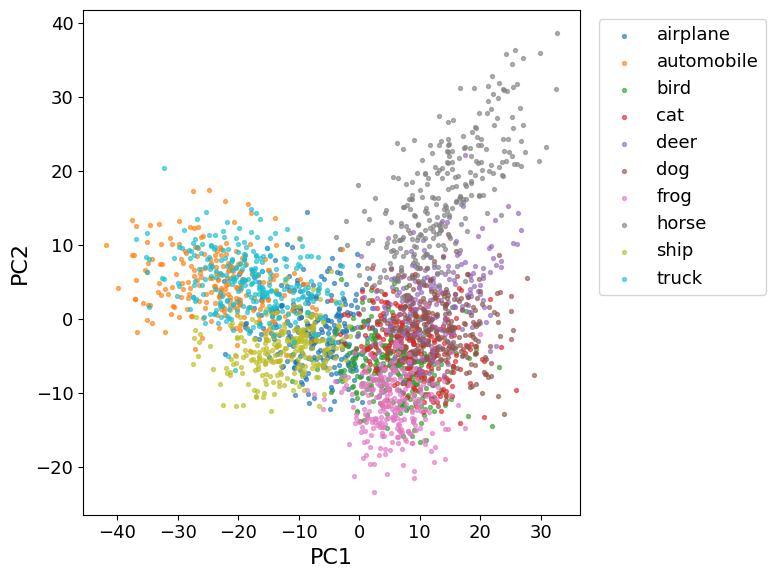

In [6]:
import matplotlib.pyplot as plt

model.eval()
embeds, labels = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(train_ld):   # use train_ld if you prefer
        x = x.to(device)
        z = model.encoder(x).cpu()
        embeds.append(z)
        labels.append(y)
        if i >= 9:   # 10 batches ≈10k points; raise/lower to taste
            break

z = torch.cat(embeds)
y = torch.cat(labels)

# 2D projection (PCA)
z0 = z - z.mean(0, keepdim=True)
U, S, V = torch.pca_lowrank(z0, q=2)
z2 = z0 @ V[:, :2]

plt.rcParams.update({
    "font.size": 14, "axes.labelsize": 16, "legend.fontsize": 13,
    "xtick.labelsize": 13, "ytick.labelsize": 13
})

plt.figure(figsize=(8, 6))
for c in range(10):
    idx = y == c
    plt.scatter(z2[idx, 0], z2[idx, 1], s=8, alpha=0.6, label=train_ds.classes[c])
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig('plots/cifar10_softmax_embeddings.png', dpi=600)
